In [2]:
!pip install gspread

     |████████████████████████████████| 152 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 3.6 MB/s  eta 0:00:01


In [4]:
!pip install gspread_pandas

In [6]:
!pip install gsheetsdb

     |████████████████████████████████| 67 kB 2.0 MB/s eta 0:00:011
  Created wheel for moz-sql-parser: filename=moz_sql_parser-4.40.21126-py3-none-any.whl size=75208 sha256=e7fdb6e63a343f795069a02751b4c9ad22cf3c639eb7f70e06e6ba4a75136914
  Stored in directory: /home/jovyan/.cache/pip/wheels/13/00/86/b49607a5b82fd02e7eea1558f3dbb1f8dc02690de926f18de5
  Created wheel for mo-dots: filename=mo_dots-4.22.21108-py3-none-any.whl size=19819 sha256=b16e685d10a70c8a9afe7d6460e516bc5423e733413219f1fa5147894d52e776
  Stored in directory: /home/jovyan/.cache/pip/wheels/93/b8/1c/8e71a4e6464944525aea97290a19f26ade5109c4be1cbaa29c
  Created wheel for mo-future: filename=mo_future-3.147.20327-py3-none-any.whl size=4516 sha256=710308ee42bdd73b0e9a0bedf8d465b3afe838c1ffd140e5a21f2ca66738ae02
  Stored in directory: /home/jovyan/.cache/pip/wheels/6b/0a/2b/d053b1795c67d7e9adee25508b7ae65087705834cccdb5a94f
  Created wheel for mo-imports: filename=mo_imports-3.149.20327-py3-none-any.whl size=5089 sha256=374

In [1]:
import streamlit as st
from google.oauth2 import service_account

scopes=[
    "https://www.googleapis.com/auth/spreadsheets",
]

# Create a connection object.
credentials = service_account.Credentials.from_service_account_info(
    st.secrets["gcp_service_account"],
    scopes=scopes,
)

2021-08-10 11:00:51.490 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [2]:
from gspread_pandas import Spread, Client

client = Client(scope=scopes, creds=credentials)
spread = Spread(st.secrets["private_gsheets_url"], client=client)

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)


In [3]:
test_df = spread.sheet_to_df(header_rows=None, index=None)

test_df

,0,1
0,A,B
1,1,a
2,2,b
3,3,c


In [42]:
df = pd.DataFrame({'A':[1,2,3], 'B':['a', 'b', 'c']})
df

,A,B
0,1,a
1,2,b
2,3,c


In [44]:
spread.df_to_sheet(df, index=False)

# Data merge

In [2]:
import pandas as pd
import streamlit as st
from google.oauth2 import service_account
from gspread_pandas import Spread, Client

class DataMerger():
    def __init__(self):
        scopes=[
            "https://www.googleapis.com/auth/spreadsheets",
        ]

        credentials = service_account.Credentials.from_service_account_info(
            st.secrets["gcp_service_account"],
            scopes=scopes,
        )
        
        client = Client(scope=scopes, creds=credentials)
        self.spread = Spread(st.secrets["private_gsheets_url"], client=client)
        self.columns = ['Transaction date', 'Description', 'Amount', 'Booked balance', 'Account', 'User']
        
    def cast(self, df):
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]], format='%Y-%m-%d').astype(str)
        df[self.columns[1]] = df[self.columns[1]].astype(str)
        df[self.columns[2:4]] = df[self.columns[2:4]].astype(float)
        df[self.columns[4:]] = df[self.columns[4:]].astype(str)
        return df
    
    def merge(self, tmp_df):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None)
        master_df = self.cast(master_df)
        merged_df = pd.concat([master_df, tmp_df], ignore_index=True)
        merged_df = merged_df.drop_duplicates()
        merged_df = merged_df.sort_values(by=self.columns[0])
        self.spread.df_to_sheet(merged_df, index=False)
        
    def swedbank(self, path, name):
        tmp_df = pd.read_excel(path, header=7)
        tmp_df = tmp_df[self.columns[:4]]
        tmp_df[self.columns[4]] = 'Swedbank'
        tmp_df[self.columns[5]] = name
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)

    def prestia(self, path, name):
        tmp_df = pd.read_csv(path, header=None, encoding='Shift-JIS')
        tmp_df = tmp_df.iloc[:,[0,2]]
        tmp_df.columns = [col for col in self.columns if col == 'Transaction date' or col == 'Amount']
        tmp_df[self.columns[0]] = tmp_df[self.columns[0]].str.replace('/', '-')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace('SEK', '')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace(',', '')
        tmp_df[self.columns[1]] = 'Not available'
        tmp_df[self.columns[3]] = 0
        tmp_df[self.columns[4]] = 'Prestia'
        tmp_df[self.columns[5]] = name
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def skandia(self, path, name):
        tmp_df = pd.read_excel(path, header=3)
        tmp_df.columns = self.columns[:4]
        tmp_df[self.columns[4]] = 'Skandia'
        tmp_df[self.columns[5]] = name
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def sony(self, path, name):
        tmp_df = pd.read_excel(path, header=0)
        tmp_df[['お預け入れ額', 'お引き出し額']] = tmp_df[['お預け入れ額', 'お引き出し額']].astype(float)
        tmp_df[['お預け入れ額', 'お引き出し額']] = tmp_df[['お預け入れ額', 'お引き出し額']].fillna(0)
        tmp_df = tmp_df.rename(columns={k:v for k,v in zip(['お取り引き日', '摘要', 'お預け入れ額', '差し引き残高'], self.columns[:4])})
        tmp_df[self.columns[0]] = pd.to_datetime(tmp_df[self.columns[0]], unit='D', origin='1899-12-30')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]] - tmp_df['お引き出し額']
        tmp_df[self.columns[4]] = 'Sony'
        tmp_df[self.columns[5]] = name
        tmp_df = tmp_df[self.columns]
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def update(self, account, path, name):
        if account == 'prestia':
            self.prestia(path, name)
        elif account == 'skandia':
            self.skandia(path, name)
        elif account == 'sony':
            self.sony(path, name)
        elif account == 'swedbank':
            self.swedbank(path, name)
        else:
            raise ValueError()

    def get_master(self):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None)
        master_df = self.cast(master_df)
        master_df[self.columns[0]] = pd.to_datetime(master_df[self.columns[0]], format='%Y-%m-%d')
        return master_df

In [149]:
dm = DataMerger()

dm.swedbank('./data/Swedbank_Transactions.xlsx', 'susumu')

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)


In [150]:
dm.prestia('./data/ACCT_252 (1).csv', 'susumu')

In [151]:
dm.skandia('./data/9159-916.791-5_2021-04-01-2021-06-21.xlsx', 'susumu')

In [152]:
dm.sony('./data/YenFutsuRireki-2019-2021-2-28.xlsx', 'hiromi')

# Predict the category

In [194]:
dm = DataMerger()

df = dm.get_master()
df

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)


,Transaction date,Description,Amount,Booked balance,Account,User,Category
0,2019-01-01,Visaデビット 236975 NHA HANG - CA PHE THOM,-711.00,1299478.00,Sony,hiromi,
1,2019-01-02,Visaデビット 171977 BIG C DANANG,12.00,1299490.00,Sony,hiromi,
2,2019-01-03,Visaデビット 314571 ACB ATM CUA DAI,-2882.00,1296616.00,Sony,hiromi,
3,2019-01-03,Visaデビット 201767 CTY TM DL MINH LONG,8.00,1299498.00,Sony,hiromi,
4,2019-01-04,Visaデビット 202908 CAFE RANG XAY HOI AN,7.00,1296623.00,Sony,hiromi,
...,...,...,...,...,...,...,...
308,2021-07-23,LÖN,30686.00,187412.32,Skandia,susumu,income
309,2021-07-28,"2021-07-27 InCharge AB, Stockholm",-59.69,187352.63,Skandia,susumu,variable
310,2021-08-02,Bredablick delay,-245.08,187107.55,Skandia,susumu,variable
311,2021-08-03,DINA FÖRSÄKRINGAR,-2526.00,184581.55,Skandia,susumu,fixed


In [85]:
filt_user = df['User'] == 'susumu'

df2 = df[filt_user]
df2['Category'].unique()

array(['income', 'variable', 'other income', 'transfer', 'fixed'],
      dtype=object)

In [152]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2[['Description', 'Amount', 'Account']], df2['Category'], test_size=0.3, random_state=42)

In [153]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
X_train['Account_label'] = le.fit_transform(X_train['Account'])

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.6, min_df=2)
vectorizer.fit(X_train['Description'])
X_train[[f'Description_{x}' for x in vectorizer.get_feature_names()]] = vectorizer.transform(X_train['Description']).toarray()

In [155]:
X_train

,Description,Amount,Account,Account_label,Description_46702669013,Description_ab,Description_allowance,Description_amazonmktplc,Description_annan,Description_ar,...,Description_lön,Description_not,Description_nyckelkund,Description_okq8,Description_payment,Description_pris,Description_swish,Description_systembolaget,Description_taby,Description_to
304,Not available,-25.00,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
239,MCD TABY CENTRU,-22.00,Swedbank,2,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
147,2020-12-03 to 20,-3513.00,Swedbank,2,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0
210,Swish payment +46705810390,-100.00,Swedbank,2,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.707107,0.0,0.707107,0.0,0.0,0.0
276,Not available,10.00,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,Not available,-20.29,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
249,JULA AB,-39.80,Swedbank,2,0.000000,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
150,Swish payment +46702669013,-488.00,Swedbank,2,0.676313,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.520865,0.0,0.520865,0.0,0.0,0.0
235,Child allowance,1325.00,Swedbank,2,0.000000,0.0,0.688482,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [156]:
vectorizer.get_feature_names()

['46702669013',
 'ab',
 'allowance',
 'amazonmktplc',
 'annan',
 'ar',
 'available',
 'bank',
 'barnbdr',
 'child',
 'deposit',
 'easypark',
 'eon',
 'från',
 'förskola',
 'insättning',
 'july',
 'lön',
 'not',
 'nyckelkund',
 'okq8',
 'payment',
 'pris',
 'swish',
 'systembolaget',
 'taby',
 'to']

In [157]:
y_train

304        variable
239        variable
147        variable
210        variable
276    other income
           ...     
214        variable
249        variable
150           fixed
235          income
245        variable
Name: Category, Length: 119, dtype: object

In [158]:
x_cols = [x for x in X_train.columns if (x != 'Description') and ( x != 'Account')]
X_train[x_cols]

,Amount,Account_label,Description_46702669013,Description_ab,Description_allowance,Description_amazonmktplc,Description_annan,Description_ar,Description_available,Description_bank,...,Description_lön,Description_not,Description_nyckelkund,Description_okq8,Description_payment,Description_pris,Description_swish,Description_systembolaget,Description_taby,Description_to
304,-25.00,0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
239,-22.00,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
147,-3513.00,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0
210,-100.00,2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.707107,0.0,0.707107,0.0,0.0,0.0
276,10.00,0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-20.29,0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.707107,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
249,-39.80,2,0.000000,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
150,-488.00,2,0.676313,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.520865,0.0,0.520865,0.0,0.0,0.0
235,1325.00,2,0.000000,0.0,0.688482,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [159]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(random_state=42)

clf.fit(X_train[x_cols], y_train)

LGBMClassifier(random_state=42)

In [160]:
X_test['Account_label'] = le.transform(X_test['Account'])
X_test[[f'Description_{x}' for x in vectorizer.get_feature_names()]] = vectorizer.transform(X_test['Description']).toarray()

X_test

,Description,Amount,Account,Account_label,Description_46702669013,Description_ab,Description_allowance,Description_amazonmktplc,Description_annan,Description_ar,...,Description_lön,Description_not,Description_nyckelkund,Description_okq8,Description_payment,Description_pris,Description_swish,Description_systembolaget,Description_taby,Description_to
282,Insättning från annan bank ÖVERFÖRING,60000.00,Skandia,1,0.000000,0.0,0.000000,0.0,0.5,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
168,Not available,-97.03,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
262,Not available,-3.24,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
167,Not available,31974.50,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
287,Not available,-300.00,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
306,"2021-07-12 AMAZONMKTPLC*UA8HZ9EI5 WW, WWW.AMAZ...",-126.78,Skandia,1,0.000000,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
309,"2021-07-27 InCharge AB, Stockholm",-59.69,Skandia,1,0.000000,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
192,Child allowance,5925.00,Swedbank,2,0.000000,0.0,0.688482,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
248,WILLYS TÄBY CENT,-30.90,Swedbank,2,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
203,Not available,-21.00,Prestia,0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [161]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test[x_cols])
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       fixed       0.20      0.50      0.29         2
      income       0.88      1.00      0.93         7
other income       0.67      0.67      0.67         3
    transfer       0.75      1.00      0.86         3
    variable       0.97      0.83      0.90        36

    accuracy                           0.84        51
   macro avg       0.69      0.80      0.73        51
weighted avg       0.89      0.84      0.86        51

[[ 1  0  0  0  1]
 [ 0  7  0  0  0]
 [ 0  0  2  1  0]
 [ 0  0  0  3  0]
 [ 4  1  1  0 30]]


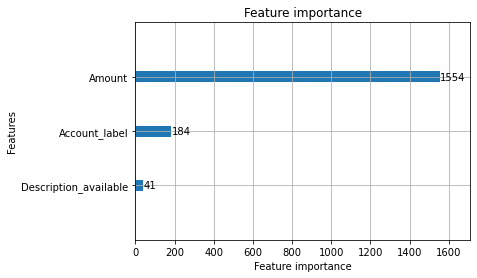

In [162]:
from lightgbm import plot_importance

plot_importance(clf);

In [218]:
clf.best_score_

defaultdict(collections.OrderedDict, {})

In [33]:
import glob
from datetime import datetime
import pandas as pd
import streamlit as st
from google.oauth2 import service_account
from gspread_pandas import Spread, Client

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from joblib import dump, load


class DataMerger():
    def __init__(self):
        scopes=[
            "https://www.googleapis.com/auth/spreadsheets",
        ]

        credentials = service_account.Credentials.from_service_account_info(
            st.secrets["gcp_service_account"],
            scopes=scopes,
        )
        
        client = Client(scope=scopes, creds=credentials)
        self.spread = Spread(st.secrets["private_gsheets_url"], client=client)
        self.columns = ['Transaction date', 'Description', 'Amount', 'Booked balance', 'Account', 'User', 'Category']
        
    def cast(self, df):
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]], format='%Y-%m-%d').astype(str)
        df[self.columns[1]] = df[self.columns[1]].astype(str)
        df[self.columns[2:4]] = df[self.columns[2:4]].astype(float)
        df[self.columns[4:]] = df[self.columns[4:]].astype(str)
        return df
    
    def merge(self, tmp_df):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None)
        master_df = self.cast(master_df)
        merged_df = pd.concat([master_df, tmp_df], ignore_index=True)
        merged_df = merged_df.drop_duplicates(subset=self.columns[:6])
        merged_df = merged_df.sort_values(by=self.columns[0])
        self.spread.df_to_sheet(merged_df, index=False)
        
    def swedbank(self, path, name):
        tmp_df = pd.read_excel(path, header=7)
        tmp_df = tmp_df[self.columns[:4]]
        tmp_df[self.columns[4]] = 'Swedbank'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)

    def prestia(self, path, name):
        tmp_df = pd.read_csv(path, header=None, encoding='Shift-JIS')
        tmp_df = tmp_df.iloc[:,[0,2]]
        tmp_df.columns = [col for col in self.columns if col == 'Transaction date' or col == 'Amount']
        tmp_df[self.columns[0]] = tmp_df[self.columns[0]].str.replace('/', '-')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace('SEK', '')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace(',', '')
        tmp_df[self.columns[1]] = 'Not available'
        tmp_df[self.columns[3]] = 0
        tmp_df[self.columns[4]] = 'Prestia'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def skandia(self, path, name):
        tmp_df = pd.read_excel(path, header=3)
        tmp_df.columns = self.columns[:4]
        tmp_df[self.columns[4]] = 'Skandia'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def sony(self, path, name):
        tmp_df = pd.read_excel(path, header=0)
        tmp_df[['お預け入れ額', 'お引き出し額']] = tmp_df[['お預け入れ額', 'お引き出し額']].astype(float)
        tmp_df[['お預け入れ額', 'お引き出し額']] = tmp_df[['お預け入れ額', 'お引き出し額']].fillna(0)
        tmp_df = tmp_df.rename(columns={k:v for k,v in zip(['お取り引き日', '摘要', 'お預け入れ額', '差し引き残高'], self.columns[:4])})
        tmp_df[self.columns[0]] = pd.to_datetime(tmp_df[self.columns[0]], unit='D', origin='1899-12-30')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]] - tmp_df['お引き出し額']
        tmp_df[self.columns[4]] = 'Sony'
        tmp_df[self.columns[5]] = name
        tmp_df = tmp_df[self.columns[:6]]
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def update(self, account, path, name):
        if account == 'prestia':
            self.prestia(path, name)
        elif account == 'skandia':
            self.skandia(path, name)
        elif account == 'sony':
            self.sony(path, name)
        elif account == 'swedbank':
            self.swedbank(path, name)
        else:
            raise ValueError()

    def get_master(self):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None)
        master_df = self.cast(master_df)
        master_df[self.columns[0]] = pd.to_datetime(master_df[self.columns[0]], format='%Y-%m-%d')
        return master_df

    def train(self, test_size=0.25, random_state=42):
        df = self.get_master()
        filt = df[self.columns[6]] != ''
        df = df[filt]
        X_train, X_test, y_train, y_test = train_test_split(df[[x for x in self.columns[1:6] if x != 'Booked balance']], df[self.columns[6]], test_size=test_size, random_state=random_state)
        
        preprocessing = ColumnTransformer([
            ('numeric', StandardScaler(), [self.columns[2]]),
            ('categorical', OneHotEncoder(), self.columns[4:6]),
            ('text', TfidfVectorizer(), self.columns[1]),
        ])
        
        model = Pipeline([
            ('preprocess', preprocessing),
            ('classifier', LGBMClassifier(random_state=random_state))
        ])
        
        model.fit(X_train, y_train)
        dump(model, f'./model/model_{datetime.today().strftime("%Y-%m-%d-%H:%M:%S")}.joblib') 
        
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        
    def pred_category(self, df, model_id=-1):
        names = glob.glob('./model/model_*')
        timestamps = pd.to_datetime([x.replace('./model/model_', '').replace('.joblib', '') for x in names], format='%Y-%m-%d-%H:%M:%S').sort_values()
        model = load(f'./model/model_{timestamps[model_id].strftime("%Y-%m-%d-%H:%M:%S")}.joblib')
        
        return model.predict(df)



In [34]:
dm = DataMerger()

dm.train()

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)
              precision    recall  f1-score   support

       fixed       0.33      1.00      0.50         1
      income       0.88      1.00      0.93         7
other income       1.00      0.33      0.50         3
    transfer       0.75      1.00      0.86         3
    variable       0.96      0.90      0.93        29

    accuracy                           0.88        43
   macro avg       0.78      0.85      0.74        43
weighted avg       0.92      0.88      0.88        43

[[ 1  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  0  1  1  1]
 [ 0  0  0  3  0]
 [ 2  1  0  0 26]]


In [8]:
import glob
import datetime

names = glob.glob('./model/model_*')
timestamps = pd.to_datetime([x.replace('./model/model_', '').replace('.joblib', '') for x in names], format='%Y-%m-%d-%H:%M:%S').sort_values()
timestamps

DatetimeIndex(['2021-08-13 08:02:57'], dtype='datetime64[ns]', freq=None)

In [9]:
model = load(f'./model/model_{timestamps[-1].strftime("%Y-%m-%d-%H:%M:%S")}.joblib') 
model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Amount']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['Account', 'User']),
                                                 ('text', TfidfVectorizer(),
                                                  'Description')])),
                ('classifier', LGBMClassifier(random_state=42))])

In [15]:
df_ = dm.get_master()
filt = df_[dm.columns[6]] != ''
df_ = df_[filt]
df_['prediction'] = model.predict(df_[['Description', 'Amount', 'Account', 'User']])

df_.sample(n=10)

,Transaction date,Description,Amount,Booked balance,Account,User,Category,prediction
253,2021-05-09,SYSTEMBOLAGET AR,-199.00,44559.91,Swedbank,susumu,variable,variable
299,2021-06-21,"Swish till HEREDIA MARIN,HERNAN",-2500.00,125249.10,Skandia,susumu,variable,fixed
268,2021-05-22,ELLOS.SE,-6944.00,38179.51,Swedbank,susumu,variable,variable
238,2021-04-26,förskola 202104,-1470.00,3708053.29,Swedbank,susumu,fixed,fixed
286,2021-06-06,Not available,-80.10,0.00,Prestia,susumu,variable,variable
170,2021-01-18,ICA KVANTUM TABY,-149.00,452253.23,Swedbank,susumu,variable,variable
209,2021-03-15,Not available,31104.27,0.00,Prestia,susumu,transfer,transfer
217,2021-03-27,Not available,-89.00,0.00,Prestia,susumu,variable,variable
290,2021-06-10,Not available,-40.00,0.00,Prestia,susumu,variable,variable
285,2021-06-06,Not available,-50.00,0.00,Prestia,susumu,variable,variable


In [18]:
dm.pred_category(df_[['Description', 'Amount', 'Account', 'User']])

array(['transfer', 'variable', 'fixed', 'income', 'variable', 'variable',
       'other income', 'income', 'fixed', 'income', 'fixed', 'variable',
       'variable', 'variable', 'fixed', 'variable', 'income', 'variable',
       'variable', 'variable', 'fixed', 'variable', 'variable',
       'transfer', 'variable', 'transfer', 'variable', 'variable',
       'variable', 'transfer', 'variable', 'variable', 'variable',
       'variable', 'variable', 'variable', 'variable', 'fixed',
       'variable', 'variable', 'income', 'fixed', 'fixed', 'variable',
       'fixed', 'variable', 'variable', 'other income', 'variable',
       'fixed', 'variable', 'income', 'variable', 'transfer', 'income',
       'variable', 'income', 'fixed', 'fixed', 'other income', 'variable',
       'variable', 'fixed', 'variable', 'variable', 'variable',
       'transfer', 'variable', 'income', 'variable', 'variable',
       'variable', 'fixed', 'income', 'variable', 'variable', 'variable',
       'fixed', 'variable', 

In [35]:
dm.prestia('./data/ACCT_252 (1).csv', 'susumu')

In [2]:
import glob
from datetime import datetime, timezone
import pytz
from tzlocal import get_localzone
import pandas as pd
import streamlit as st
from google.oauth2 import service_account
from gspread_pandas import Spread, Client

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from joblib import dump, load


class DataMerger():
    def __init__(self):
        scopes=[
            "https://www.googleapis.com/auth/spreadsheets",
        ]

        credentials = service_account.Credentials.from_service_account_info(
            st.secrets["gcp_service_account"],
            scopes=scopes,
        )
        
        client = Client(scope=scopes, creds=credentials)
        self.spread = Spread(st.secrets["private_gsheets_url"], client=client, sheet='book')
        self.columns = ['Transaction date', 'Description', 'Amount', 'Booked balance', 'Account', 'User', 'Category']
        
    def cast(self, df):
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]], format='%Y-%m-%d').astype(str)
        df[self.columns[1]] = df[self.columns[1]].astype(str)
        df[self.columns[2:4]] = df[self.columns[2:4]].astype(float)
        df[self.columns[4:]] = df[self.columns[4:]].astype(str)
        return df
    
    def merge(self, tmp_df):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None)
        master_df = self.cast(master_df)
        merged_df = pd.concat([master_df, tmp_df], ignore_index=True)
        merged_df = merged_df.drop_duplicates(subset=self.columns[:6])
        merged_df = merged_df.sort_values(by=self.columns[0])
        self.spread.df_to_sheet(merged_df, index=False)
        
    def swedbank(self, path, name):
        tmp_df = pd.read_excel(path, header=7)
        tmp_df = tmp_df[self.columns[:4]]
        tmp_df[self.columns[4]] = 'Swedbank'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)

    def prestia(self, path, name):
        tmp_df = pd.read_csv(path, header=None, encoding='Shift-JIS')
        tmp_df = tmp_df.iloc[:,[0,2]]
        tmp_df.columns = [col for col in self.columns if col == 'Transaction date' or col == 'Amount']
        tmp_df[self.columns[0]] = tmp_df[self.columns[0]].str.replace('/', '-')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace('SEK', '')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]].str.replace(',', '')
        tmp_df[self.columns[1]] = 'Not available'
        tmp_df[self.columns[3]] = 0
        tmp_df[self.columns[4]] = 'Prestia'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def skandia(self, path, name):
        tmp_df = pd.read_excel(path, header=3)
        tmp_df.columns = self.columns[:4]
        tmp_df[self.columns[4]] = 'Skandia'
        tmp_df[self.columns[5]] = name
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def sony(self, path, name):
        # tmp_df = pd.read_excel(path, header=0)
        tmp_df = pd.read_csv(path, header=0, encoding='Shift-JIS', dtype={'お取り引き日': str, '摘要': str, 'お預け入れ額': str, 'お引き出し額': str, '差引残高': str},
        na_filter=False,
        )
        tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']] = tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']].replace('', '0')
        tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']] = tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']].applymap(lambda x: str(x).replace(',', ''))
        tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']] = tmp_df[['お預け入れ額', 'お引き出し額', '差引残高']].astype(float)
        tmp_df = tmp_df.rename(columns={k:v for k,v in zip(['お取り引き日', '摘要', 'お預け入れ額', '差引残高'], self.columns[:4])})
        tmp_df[self.columns[0]] = pd.to_datetime(tmp_df[self.columns[0]], format='%Y年%m月%d日')
        tmp_df[self.columns[2]] = tmp_df[self.columns[2]] - tmp_df['お引き出し額']
        tmp_df[self.columns[4]] = 'Sony'
        tmp_df[self.columns[5]] = name
        tmp_df = tmp_df[self.columns[:6]]
        tmp_df[self.columns[6]] = self.pred_category(tmp_df[[x for x in self.columns[1:6] if x != 'Booked balance']])
        # tmp_df[self.columns[6]] = ''
        print(tmp_df.shape)
        tmp_df = self.cast(tmp_df)
        self.merge(tmp_df)
        
    def backup(self):
        master_df = self.get_master()
        master_df = self.cast(master_df)
        name = f'backup_{self.CET_today().strftime("%Y-%m-%d-%H:%M:%S")}'
        self.spread.df_to_sheet(master_df, index=False, sheet=name)
    
    def update(self, account, path, name):
        self.backup()
        
        if account == 'prestia':
            self.prestia(path, name)
            return
        elif account == 'skandia':
            self.skandia(path, name)
            return
        elif account == 'sony':
            self.sony(path, name)
            return
        elif account == 'swedbank':
            self.swedbank(path, name)
            return
        else:
            raise ValueError()

    def get_master(self):
        master_df = self.spread.sheet_to_df(header_rows=1, index=None, sheet='book')
        master_df = self.cast(master_df)
        master_df[self.columns[0]] = pd.to_datetime(master_df[self.columns[0]], format='%Y-%m-%d')
        return master_df

    def train(self, test_size=0.25, random_state=42):
        train_df = self.get_master()
        filt = train_df[self.columns[6]] != ''
        train_df = train_df[filt]
        X_train, X_test, y_train, y_test = train_test_split(train_df[[x for x in self.columns[1:6] if x != 'Booked balance']], train_df[self.columns[6]], test_size=test_size, random_state=random_state)
        
        preprocessing = ColumnTransformer([
            ('numeric', StandardScaler(), [self.columns[2]]),
            ('categorical', OneHotEncoder(), self.columns[4:6]),
            ('text', TfidfVectorizer(), self.columns[1]),
        ])
        
        model = Pipeline([
            ('preprocess', preprocessing),
            ('classifier', LGBMClassifier(random_state=random_state))
        ])
        
        model.fit(X_train, y_train)
        dump(model, f'./model/model_{self.CET_today().strftime("%Y-%m-%d-%H:%M:%S")}.joblib') 
        
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        
    def pred_category(self, pred_df, model_id=-1):
        names = glob.glob('./model/model_*')
        timestamps = pd.to_datetime([x.replace('./model/model_', '').replace('.joblib', '') for x in names], format='%Y-%m-%d-%H:%M:%S').sort_values()
        model = load(f'./model/model_{timestamps[model_id].strftime("%Y-%m-%d-%H:%M:%S")}.joblib')
        
        return model.predict(pred_df)

    def CET_today(self):
        utc_dt = datetime.now(timezone.utc)
        CET = pytz.timezone('CET')
        return utc_dt.astimezone(CET)

In [3]:
dm = DataMerger()

dm.train()

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)
              precision    recall  f1-score   support

       fixed       0.86      0.75      0.80         8
      income       1.00      0.50      0.67         4
other income       0.57      1.00      0.73         4
    transfer       1.00      0.75      0.86         4
    variable       0.98      0.99      0.99       110

    accuracy                           0.95       130
   macro avg       0.88      0.80      0.81       130
weighted avg       0.96      0.95      0.95       130

[[  6   0   0   0   2]
 [  0   2   2   0   0]
 [  0   0   4   0   0]
 [  0   0   1   3   0]
 [  1   0   0   0 109]]


In [4]:
dm.backup()

In [1]:
from DataMerger import DataMerger

dm = DataMerger()
dm.train()

Your credentials don't have Drive API access, ignoring drive specific functionality (Note this includes searching spreadsheets by name)
              precision    recall  f1-score   support

       fixed       1.00      0.62      0.76        13
      income       1.00      0.75      0.86        12
other income       0.20      0.25      0.22         4
    transfer       0.50      0.75      0.60         4
    variable       0.95      1.00      0.98       106

    accuracy                           0.91       139
   macro avg       0.73      0.67      0.68       139
weighted avg       0.93      0.91      0.91       139

[[  8   0   0   0   5]
 [  0   9   3   0   0]
 [  0   0   1   3   0]
 [  0   0   1   3   0]
 [  0   0   0   0 106]]
